In [1]:
!pip3 install tensorflow-estimator==2.6.0

In [2]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈 
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile 
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [6]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [7]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False): 
  
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [8]:
def draw_bounding_box_on_image(image, 
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [9]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1): 
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmp2gbt3mnu.jpg.


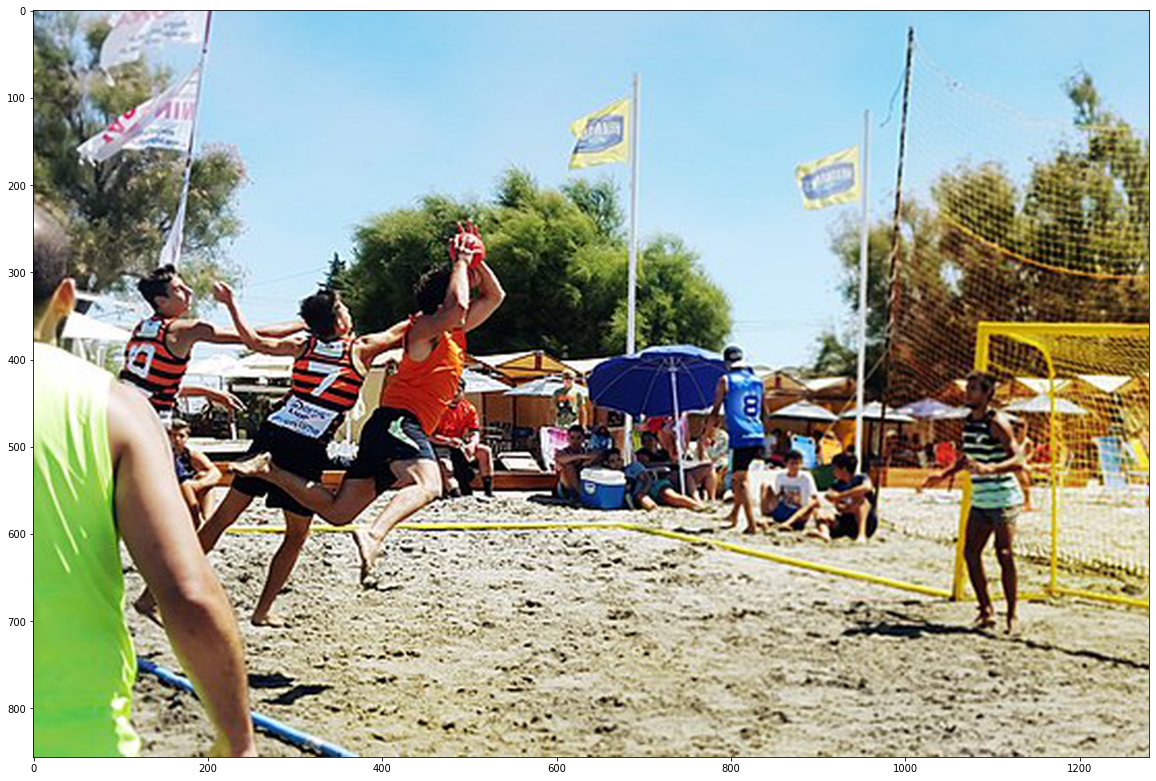

In [10]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)  # new_width와 new_height를 변경해 보세요.

In [11]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"  

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [12]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [13]:
def run_detector(detector, path):
  img = load_img(path) 

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  44.08793926239014


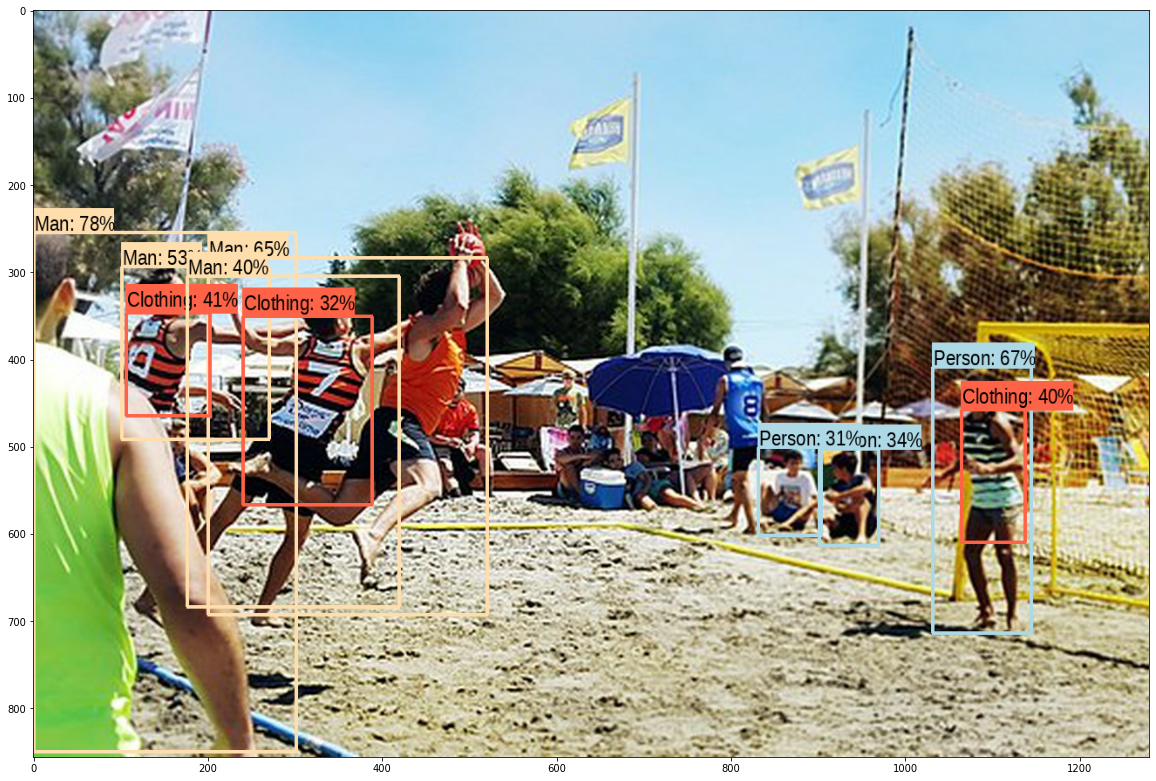

In [14]:
run_detector(detector, downloaded_image_path)

Image downloaded to /tmp/tmp7_1on232.jpg.


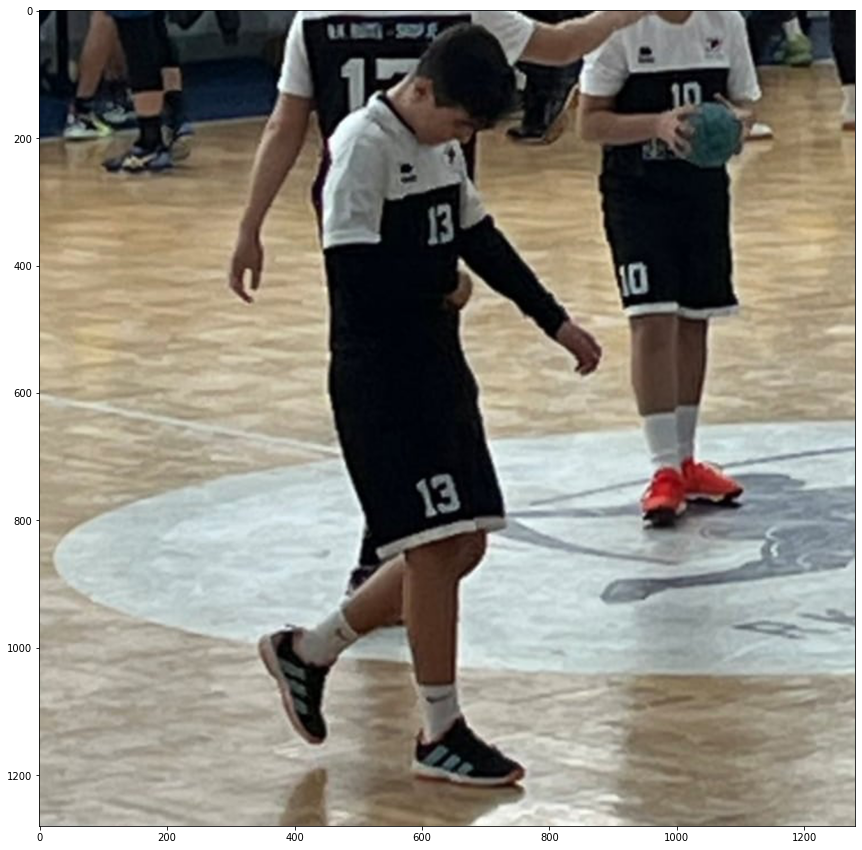

In [15]:
# 이미지 불러오기
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/6c/0-02-05-d48b345cae42874f2884d9b44d44901ad57753d5bd8b6050f9540a054f0a5db8_14df8022ebaef242.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 1280, True)

Found 100 objects.
Inference time:  2.8869259357452393


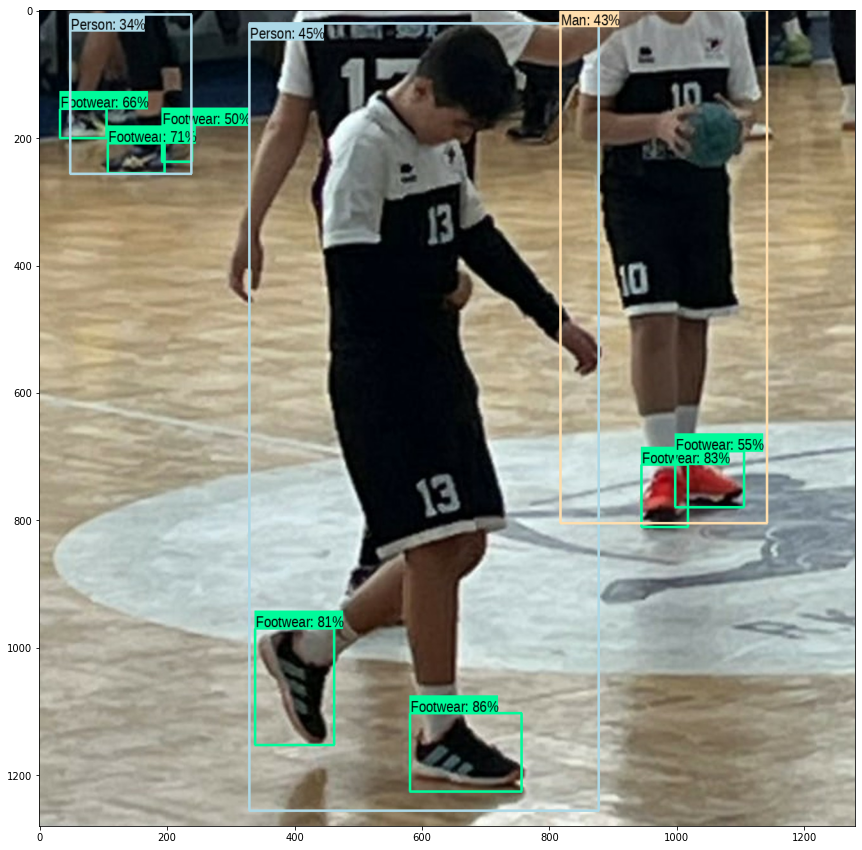

In [16]:
# 테스트
run_detector(detector, downloaded_image_path)

In [17]:
# 문제 2-2. 모델 불러오기
module_handle = "https://www.kaggle.com/models/tensorflow/mask-rcnn-inception-resnet-v2/TensorFlow2/1024x1024/1"
model = hub.load(module_handle)

Image downloaded to /tmp/tmplr0ytunx.jpg.
dict_keys(['num_proposals', 'rpn_objectness_predictions_with_background', 'raw_detection_boxes', 'proposal_boxes_normalized', 'detection_classes', 'mask_predictions', 'raw_detection_scores', 'box_classifier_features', 'rpn_features_to_crop', 'final_anchors', 'proposal_boxes', 'class_predictions_with_background', 'detection_multiclass_scores', 'rpn_box_encodings', 'image_shape', 'detection_masks', 'anchors', 'detection_boxes', 'detection_anchor_indices', 'rpn_box_predictor_features', 'detection_scores', 'num_detections', 'refined_box_encodings'])
Detection scores: [[0.949122   0.92202425 0.908036   0.90184456 0.87682164 0.86671245
  0.85996884 0.78639764 0.7649068  0.7093224  0.6531197  0.6154994
  0.6151712  0.6075543  0.6069551  0.5890443  0.5801315  0.57411367
  0.57383674 0.5562072  0.50965834 0.4338273  0.41761795 0.4100258
  0.3757335  0.3553751  0.34440097 0.34284103 0.27830023 0.26407182
  0.2581997  0.23990992 0.22771907 0.22132102 0.19

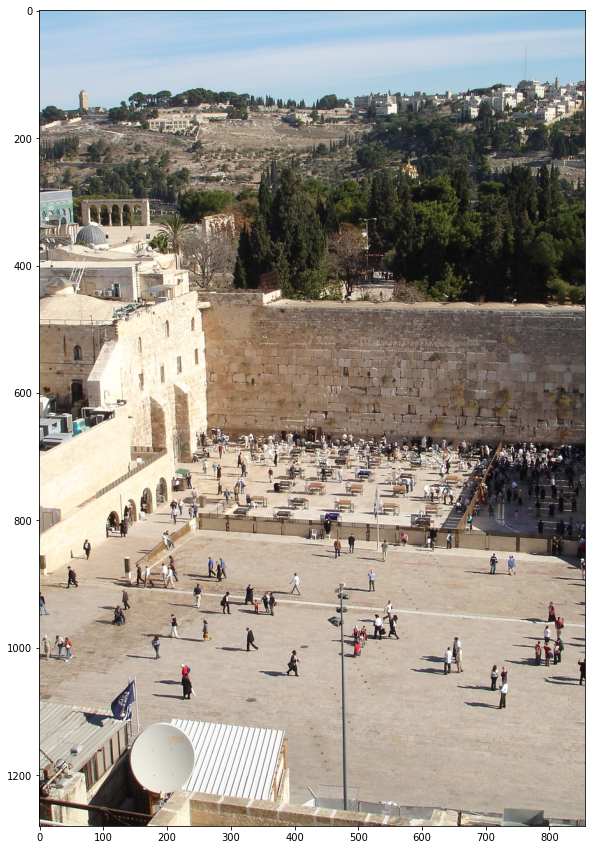

In [18]:
# 문제 2-2. 테스트 
image_url2 = "https://upload.wikimedia.org/wikipedia/commons/1/17/Westernwall2.jpg"
downloaded_image_path2 = download_and_resize_image(image_url2, 856, 1280, True)

def convert_float_to_uint8(image):
    # 이미지 데이터가 0.0과 1.0 사이라고 가정하고 255를 곱해줍니다.
    # 만약 데이터가 0~255 범위로 정규화되지 않았다면, 먼저 정규화 과정을 거쳐야 할 수 있습니다.
    image_uint8 = tf.image.convert_image_dtype(image, tf.uint8, saturate=True)
    return image_uint8


def run_detector2(model, path):
    img = load_img(path)
    converted_img = convert_float_to_uint8(img)
    image_with_batch = converted_img[tf.newaxis, ...]
    
    result = model(image_with_batch)
    result = {key:value.numpy() for key, value in result.items()}
    print(result.keys())  # 결과의 키 출력해 구조 이해하기

    return result

# 모델 실행
results = run_detector2(model, downloaded_image_path2)

# 결과 출력 예시
print("Detection scores:", results['detection_scores'])
print("Detection classes:", results['detection_classes'])

In [19]:
# 문제 2-2. 결과 비교
print("1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.")
print("2번째 모델인 Mask RCNN은 어떻게 사용한지 잘 모르겠습니다............모델 학습하고 테스트까지 했는데 이미지로 보여주는 방법을 못 찾았습니다.")

1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.
2번째 모델인 Mask RCNN은 어떻게 사용한지 잘 모르겠습니다............모델 학습하고 테스트까지 했는데 이미지로 보여주는 방법을 못 찾았습니다.
